Link to the slides: https://drive.google.com/file/d/1wlTt949oOvvP2x5URxk6I9AlUd2mlTLe/view
Link to the article: https://vincmazet.github.io/bip/detection/corners.html

## Init

In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

img2tensor = transforms.ToTensor()
img2grayscale = transforms.Grayscale()
def plot_tensor(t): 
    plt.figure(figsize=(10,10))
    plt.imshow(t.permute(1, 2, 0).detach().cpu())
    
def plot_b_tensor(t): 
    plt.figure(figsize=(10,10))
    plt.imshow(t.squeeze(0).permute(1, 2, 0).detach().cpu())
    
def min_max_norm(t):
    t -= t.min()
    t /= t.max()
    return t

eps = 1e-6

In [2]:
image_path = Path('assets/corners.jpg')
print(f'Image exists: {image_path.exists()}')

img_t = img2tensor(Image.open(image_path)).unsqueeze(0)

Image exists: True


In [3]:
img_t.shape

torch.Size([1, 3, 852, 1280])

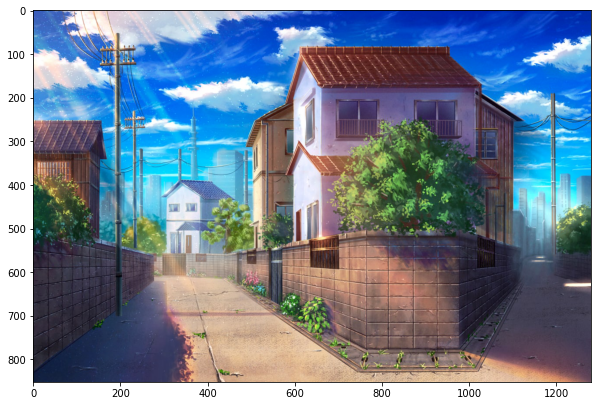

In [4]:
plot_b_tensor(img_t)

## Implementation

In [5]:
guassian_f = torchvision.transforms.GaussianBlur(7, sigma=(1, 1))

In [6]:
gray_img_t = img2grayscale(img_t)

B, C, H, W = gray_img_t.shape
kernel_size = 3
energy_t = torch.zeros(B, C, kernel_size, kernel_size, H, W)
pad = kernel_size-1
pad_img = F.pad(gray_img_t, (pad, pad, pad, pad), mode='replicate') 

for u in range(kernel_size):
    for v in range(kernel_size):
        energy_t[:, :, u, v, :, :] = guassian_f((gray_img_t - pad_img[:, :, u:H+u, v:W+v]).pow(2))
        
        
energy_t[:,:,pad,pad,:,:] = 100000.
out = energy_t.min(dim=2)[0].min(dim=2)[0]

out = min_max_norm(out)

print(f"out.max(): {out.max()}")

threshold = 0.05
out[out>threshold] = 1
out[out<threshold] = 0

out.max(): 1.0


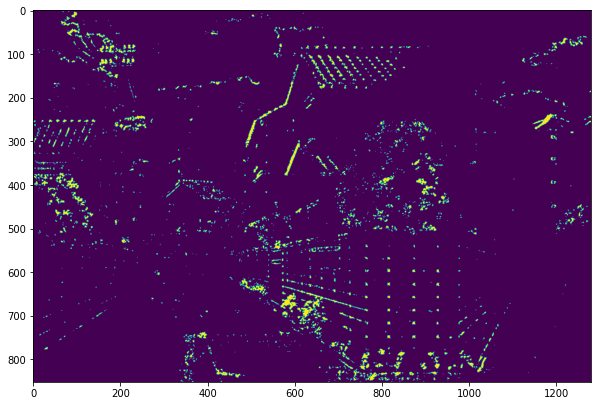

In [7]:
plot_b_tensor(out)

In [8]:
img_t[:, :1, :, :][out==1] = 1.
img_t[:, 1:2, :, :][out==1] = 0.
img_t[:, 2:, :, :][out==1] = 0.

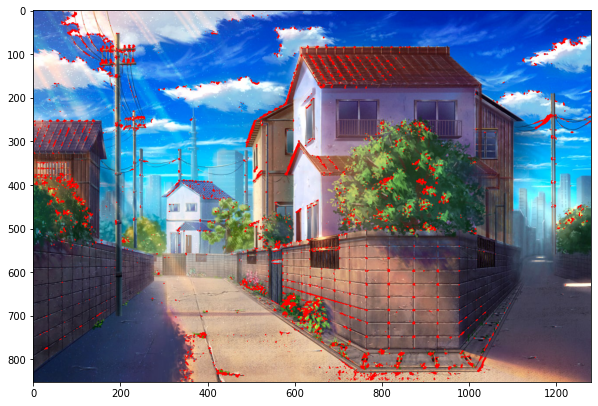

In [9]:
plot_b_tensor(img_t)

## Try to apply sobel filter first and then apply morovec corner detection

In [10]:
sobel_filter_x = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]]).float().unsqueeze(0)

sobel_filter_y = torch.tensor([[1, 2, 1],
                                [0, 0, 0],
                                [-1, -2, -1]]).float().unsqueeze(0)

sobel_filter = torch.cat([sobel_filter_x, sobel_filter_y]).unsqueeze(1)

def sobel_detection(x):
    grads = torch.conv2d(x, sobel_filter, stride=1, padding='same')[0]
    magnitude = torch.sqrt(grads[0]**2 + grads[1]**2)
    return magnitude.unsqueeze(0).unsqueeze(0)

In [13]:
grad_img = sobel_detection(gray_img_t)

B, C, H, W = grad_img.shape
kernel_size = 3
energy_t = torch.zeros(B, C, kernel_size, kernel_size, H, W)
pad = kernel_size-1
pad_img = F.pad(grad_img, (pad, pad, pad, pad), mode='replicate') 

for u in range(kernel_size):
    for v in range(kernel_size):
        energy_t[:, :, u, v, :, :] = guassian_f((grad_img - pad_img[:, :, u:H+u, v:W+v]).pow(2))
        
        
energy_t[:,:,pad,pad,:,:] = 100000.
out = energy_t.min(dim=2)[0].min(dim=2)[0]

out = min_max_norm(out)

print(f"out.max(): {out.max()}")

threshold = 0.05
out[out>threshold] = 1
out[out<threshold] = 0

out.max(): 1.0


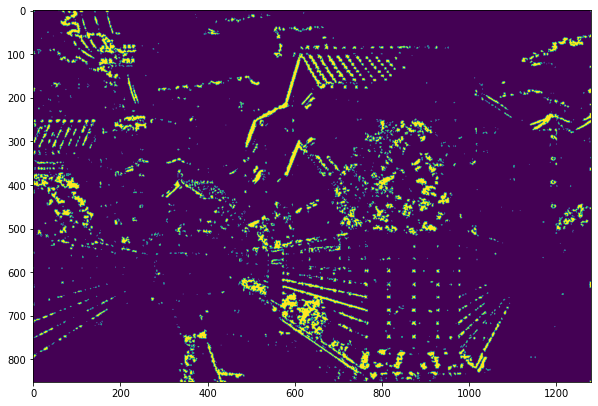

In [14]:
plot_b_tensor(out)